In [2]:
import numpy as np
import gymnasium as gym
import random
import matplotlib 
# matplotlib.use('Qt5Agg')  #depending on what's installed
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import deque
from collections import defaultdict  # required for creating Q(s, a)
from moviepy import ImageSequenceClip # to generate gif
from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

### Frozen Lake

* **States**: The environment consists of 16 discrete states, representing the grid's cells.
* **Actions**: The agent can take one of four actions: left, down, right, or up.
* **Goal**: The goal is to navigate to the 'G' state.
* **Rewards**: The agent receives a reward of `1` for reaching the goal state, and the episode terminates if it falls into a hole, which yields a reward of `0`.

Since you've set `is_slippery=False`, the environment is **deterministic**, meaning that the agent will always move exactly as instructed by its actions, without any randomness in how the environment behaves.




In [3]:
# Default reward schedule:

# Reach goal: +1

# Reach hole: 0

# Reach frozen: 0





# 0: Move left

# 1: Move down

# 2: Move right

# 3: Move up


# The observation is a value representing the player’s current position as 
# current_row * ncols + current_col (where both the row and col start at 0).
# Therefore, the observation is returned as an integer.
# For example, the goal position in the 4x4 map can be calculated as 
# follows: 3 * 4 + 3 = 15. The number of possible observations is dependent on the size of the map.

env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False)

In [4]:

# Keep returns of last 100 episodes
last_rewards = deque(maxlen=100)

# Hyperparameters
num_episodes = 5000
gamma = 0.99 # Discount factor
epsilon = 0.5 # Exploration rate for epsilon-greedy

# Initialize Q(s, a) and returns
# The key difference between a defaultdict and 
# a regular dict is that it provides a default value for nonexistent keys.
# In this case, the default value is defined by the 
# lambda function (lambda: np.zeros(env.action_space.n)), meaning if a 
# state-action pair is accessed that hasn’t been encountered yet, 
# the defaultdict will return an array of zeros of the appropriate size.
Q = defaultdict(lambda: np.zeros(env.action_space.n))
returns = defaultdict(list)


In [5]:
# To provide a better exploration, we use epsilon greedy
# ε-greedy policy
def epsilon_greedy_policy(state,epsilon):
    if np.random.random() < epsilon:
        return env.action_space.sample()  # Explore
    else:
        return np.argmax(Q[state])        # Exploit best known action

In [6]:

# Monte Carlo First-Visit Control
for episode_idx in range(num_episodes):
    state, _ = env.reset()
    episode = []
    done = False
    total_reward = 0
    
    # At the beginning, the agent doesn’t 
    # know anything about the environment — exploration 
    # helps it learn which actions lead to rewards.
    # Epsilon is decreased after the first half of 
    # the training episodes are complete.
    if(episode_idx>num_episodes/2): 
        epsilon *=0.95

    # Generate an episode
    while not done:
        action = epsilon_greedy_policy(state,epsilon)
        next_state, reward, done, truncate, _ = env.step(action)
        done = done or truncate
        episode.append((state, action, reward))
        total_reward += reward
        state = next_state

    # Track first-visit returns
    visited = set()
    G = 0
    # The first time we see a (state, action) pair during
    # the reverse traversal corresponds to its first occurrence in forward time.
    for t in reversed(range(len(episode))):
        state, action, reward = episode[t]
        G = gamma * G + reward
        if (state, action) not in visited: 
            visited.add((state, action))
            returns[(state, action)].append(G)
            Q[state][action] = np.mean(returns[(state, action)])

            
    last_rewards.append(total_reward)
    mean_reward = round(sum(last_rewards) / len(last_rewards), 2)
    # Print progress
    if (episode_idx + 1) % 100 == 0:
        print(f"Episode {episode_idx + 1}, Total Reward: {total_reward}, Mean Reward (last 100): {mean_reward},  epsilon:{round(epsilon,3)}")
        
    
    # early stop condition
    if(mean_reward==1):
        print("\n✅ Training completed!")
        break
        
    

Episode 100, Total Reward: 0, Mean Reward (last 100): 0.0,  epsilon:0.5
Episode 200, Total Reward: 0, Mean Reward (last 100): 0.0,  epsilon:0.5
Episode 300, Total Reward: 0, Mean Reward (last 100): 0.0,  epsilon:0.5
Episode 400, Total Reward: 0, Mean Reward (last 100): 0.0,  epsilon:0.5
Episode 500, Total Reward: 0, Mean Reward (last 100): 0.0,  epsilon:0.5
Episode 600, Total Reward: 0, Mean Reward (last 100): 0.0,  epsilon:0.5
Episode 700, Total Reward: 0, Mean Reward (last 100): 0.0,  epsilon:0.5
Episode 800, Total Reward: 0, Mean Reward (last 100): 0.0,  epsilon:0.5
Episode 900, Total Reward: 0, Mean Reward (last 100): 0.0,  epsilon:0.5
Episode 1000, Total Reward: 0, Mean Reward (last 100): 0.0,  epsilon:0.5
Episode 1100, Total Reward: 0, Mean Reward (last 100): 0.02,  epsilon:0.5
Episode 1200, Total Reward: 0, Mean Reward (last 100): 0.25,  epsilon:0.5
Episode 1300, Total Reward: 1, Mean Reward (last 100): 0.36,  epsilon:0.5
Episode 1400, Total Reward: 0, Mean Reward (last 100): 0.

In [7]:

# Derive the greedy policy from Q
trained_policy = np.zeros(env.observation_space.n, dtype=int)
for s in range(env.observation_space.n):
    trained_policy[s] = np.argmax(Q[s])


print("Derived greedy policy (action for each state):")
print(trained_policy)

Derived greedy policy (action for each state):
[2 2 1 0 1 0 1 0 2 1 1 0 0 2 2 0]


In [8]:
# -------------------------
# Render Policy Using RGB Frames
# -------------------------



def create_gif(frames, filename, fps=5):
    """Creates a GIF animation from a list of frames."""
    clip = ImageSequenceClip(frames, fps=fps)
    clip.write_gif(filename, fps=fps)
    
    
def run_multi_episodes(env, policy, num_episodes=3):
    total_frames = []
    total_reward = []
    total_steps = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        steps = 0
        while not done and steps < 8: # A good solution is obtained less than 8 actions
            # Capture the rendered frame
            frame = env.render()
            total_frames.append(frame)

            # Take action from learned policy
            action = policy[state]
            state, reward, done, truncated, info = env_vis.step(action)
            episode_reward += reward
            steps += 1
        total_reward.append(episode_reward)
        total_steps.append(steps)
    return total_frames, total_steps, total_reward


In [9]:
env_vis = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode='rgb_array')  
total_frames, total_steps, total_reward = run_multi_episodes(env_vis, trained_policy, num_episodes=1)
print('pls wait, we are generating gif...')
# Decrease fps to see movement clearly.
create_gif(total_frames, f"FrozenLake-MC-first-visit.gif", fps=2) 

print(f"\n\nThere are {len(total_steps)} episodes:\n")
for i,t in enumerate(zip(total_steps,total_reward)):
    print(f'    -- Epsiode {i}      length {t[0]}      return {t[1]}')


pls wait, we are generating gif...
MoviePy - Building file FrozenLake-MC-first-visit.gif with imageio.




There are 1 episodes:

    -- Epsiode 0      length 6      return 1


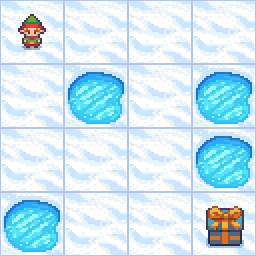

In [10]:
Image(filename='./FrozenLake-MC-first-visit.gif')